In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn import set_config
set_config(display='diagram')

# Should an order should be sent to a technical approver

In this problem, I build a Machine Learning model that makes decisions about whether to send an order to a technical approver or not.
This problem is based on Chapter 2 of [*Machine Learning for Business*](https://www.manning.com/books/machine-learning-for-business).

<img src="ML for business.png" alt="Drawing" style="width: 150px;"/>

You work in the purchasing department of a company. 
Your job is to receive requisitions from staff to buy a product or service.
For some products, such as computers, you need to send the request to a technical advisor.
Hence, when an order comes in, you need to decide whether to send it straight to the requester's financial approver or whether you should send it to a technical approver first.

![im](im1.png)

In [2]:
# load data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/orders_with_predicted_value.csv'
orders = pd.read_csv(url)
orders.head(5) 

,tech_approval_required,requester_id,role,product,quantity,price,total
0,0,E2300,tech,Desk,1,664,664
1,0,E2300,tech,Keyboard,9,649,5841
2,0,E2374,non-tech,Keyboard,1,821,821
3,1,E2374,non-tech,Desktop Computer,24,655,15720
4,0,E2327,non-tech,Desk,1,758,758


The dataset consistis of 1000 historical orders, and a flag that indicates whether that order was sent to a technical approver or not (the `tech_approval_required`).

In [3]:
orders.tech_approval_required.value_counts()

0    807
1    193
Name: tech_approval_required, dtype: int64

Your end goal is to be able to submit an order to a Machine Learning model and have it return a result that recommends sending the order to a technical approver or not.

**Part 1:** Define the feature matrix X and the target vector y from the `orders` dataframe,  and then split X and y into training and testing sets.

In [4]:
# your code here
x=orders.drop(['tech_approval_required','requester_id'],axis=1)
x

,role,product,quantity,price,total
0,tech,Desk,1,664,664
1,tech,Keyboard,9,649,5841
2,non-tech,Keyboard,1,821,821
3,non-tech,Desktop Computer,24,655,15720
4,non-tech,Desk,1,758,758
...,...,...,...,...,...
995,non-tech,Laptop Computer,1,116,116
996,non-tech,Laptop Computer,1,1132,1132
997,non-tech,Keyboard,2,804,1608
998,non-tech,Desk,3,270,810


In [5]:
y=orders.tech_approval_required

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y)

**Part 3:** build a classification pipeline (feature preprocessor + Classification Tree)

In [7]:
numerical_features=['quantity','price','total']
numerical_processor= Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',MinMaxScaler())
])

In [8]:
categorical_features=['role','product']
categorical_processor= Pipeline(steps=[
    ('imputer',SimpleImputer(strategy= 'most_frequent')),
    ('encoder',OneHotEncoder())
])

In [9]:
# your code here
processor= ColumnTransformer(transformers=[
    ('cat_process',categorical_processor,categorical_features),
    ('num_process',numerical_processor,numerical_features)
],remainder='drop')

In [10]:
pipe= Pipeline(steps=[
    ('processor',processor),
    ('tree_clf',DecisionTreeClassifier())
])

In [11]:
pipe

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cat_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['role', 'product']),
                                                 ('num_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['quantity', 'price',
                                                   'total'])])),
                ('tree_clf', DecisionTreeClassifier())])

**Part 4:** Use `GridSearchCV` to find a good `max_depth` value.

In [12]:
# your code here
param_dic ={'tree_clf__max_depth':[2,5,10,20],
            'tree_clf__min_samples_split':[16,32,64,128],
            'tree_clf__min_samples_leaf':[16,32,64,128]}

In [13]:
grid=GridSearchCV(pipe,
                  param_dic,
                  cv=10,
                  scoring='accuracy',
                  n_jobs=-1,verbose=1)

In [14]:
grid.fit(x_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('cat_process',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['role',
                                                                          'product']),
                                                                        ('num_process',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['quantity',
                                                                          'price',
                                                                          'total'])])),
                                       ('tree_clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree_clf__max_depth': [2, 5, 10, 20],
                         'tree_clf__min_samples_leaf': [16, 32, 64, 128],
                         'tree_clf__min_samples_split': [16, 32, 64, 128]},
             scoring='accuracy', verbose=1)

In [15]:
grid.best_score_

0.9866666666666667

In [16]:
grid.best_params_

{'tree_clf__max_depth': 2,
 'tree_clf__min_samples_leaf': 16,
 'tree_clf__min_samples_split': 16}

**Part 5:**  Evaluate the performance of your classification pipeline on the test set

In [17]:
best_clf=grid.best_estimator_

In [18]:
# your code here
best_clf.fit(x_train,y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cat_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['role', 'product']),
                                                 ('num_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['quantity', 'price',
                                                   'total'])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=16,
                                        min_samples_split=16))])

In [19]:
y_test_pred= best_clf.predict(x_test)

In [20]:
accuracy_score(y_test,y_test_pred)

0.992

**Part 6:** Use the `plot_tree` function to visualize the pipeline classification tree.

In [21]:
# your code here
from sklearn.tree import plot_tree

In [22]:
best_clf.fit(x_train,y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('cat_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['role', 'product']),
                                                 ('num_process',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['quantity', 'price',
                                                   'total'])])),
                ('tree_clf',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=16,
                                        min_samples_split=16))])

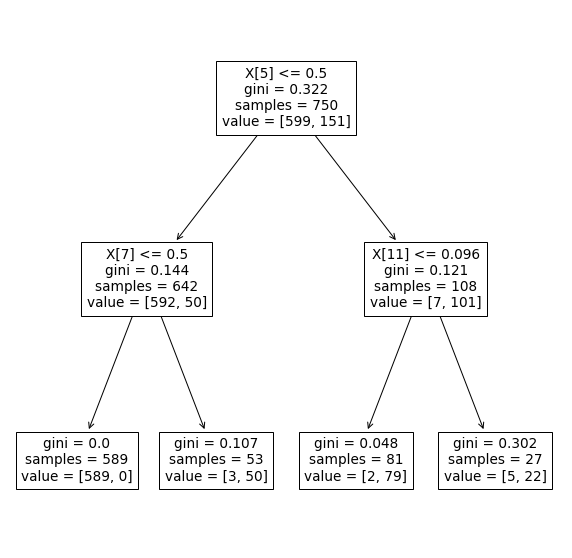

In [26]:
plt.figure(figsize=(10,10))
_ =plot_tree(best_clf['tree_clf'])


**Part 7:** Describe with words how the classification tree makes predictions.

## Random Forests
- Random forests make subsets from the data.
- They then use each of the subsets to train a classification trees
- Once you have fitted each tree they will each make predictions
- The majority vote of all the leaf nodes will become the prediction